<a href="https://colab.research.google.com/github/primasr/TugasTeknologiMultimedia/blob/main/Lossless_vs_Lossy_Tekmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# remove alpha channel from image then save it
im = Image.open('FOTO IJAZAH.png')
im_arr = np.array(im)
im_arr = im_arr[:,:,:3]
Image.fromarray(im_arr).save('foto_rgb.png')

In [ ]:
import os, sys

class RLEBitmap:
    width = 0
    height = 0
    pixels = None
    image = None
    
    #basic constructor
    def __init__(self):
        self.image = None
        self.pixels = None
        self.height = 0
        self.width = 0
    
    def open_png(self, filename):
        #open up the image
        self.image = Image.open(filename)
        #get the pixel data
        self.pixels = self.image.load()
        #get the width and height 
        self.width, self.height = self.image.size
    
    def get_color_atpoint(self, point):
        #return the pixel color as a tuple, at the given point
        return (self.pixels[point[0], point[1]])
    
    #read an image from a file stream
    def read_rle_fromstream(self, stream):
        #colors used within the image, this can be a list and not a dictionary
        colors = []
        colorCount = 0
        colorIndex = 0
        
        #iterator data
        i = 0
        x = 0
        y = 0
        
        #reset bitmap data
        self.image = None
        self.pixels = None
        
        #read in and skip the first line, it's the header description
        stream.readline()
        #get the image width and height
        self.width = int(stream.readline().split(':')[1])
        self.height = int(stream.readline().split(':')[1])
        #skip the new line
        stream.readline()
        
        #set up our bitmap in memory
        self.image = Image.new("RGB", (self.width, self.height))
        
        #read in the image palette, and skip the first line as it's the palette description
        stream.readline()
        
        #interate through until we hit whitespace
        sI = stream.readline()
        while not sI.isspace():
            #split the line into rgb components
            sISplit = sI.split(',')
            #read in the values as an RGB tuple 
            colors.append((int(sISplit[0]), int(sISplit[1]), int(sISplit[2])))
            #read in the next new line
            sI = stream.readline()
        
        #now we read in the pixel count, and skip the first line as it's the header description
        stream.readline()
        
        #iterate through until we hit whitespae
        #first line
        sI = stream.readline()
        while not sI.isspace():
            #split the line into index/count components
            sISplit = sI.split(':')
            #get the RGB index value that we need based on index
            colorIndex = int(sISplit[0])
            #get the count of how many times we need to loop through this color
            colorCount = int(sISplit[1])
            
            i = 0
            for i in range(0, colorCount):
                self.image.putpixel((x, y), colors[colorIndex])
                x += 1
                
                if (x == (self.width)):
                    x = 0
                    y += 1
                    
            #read in the next new line    
            sI = stream.readline()
        
        #once the image has been constructed in memory, dump the pixel data into a table
        self.pixels = self.image.load()
        
    #write the image in memory to file 
    def write_memory_tofile(self, filename):
        if (self.image != None):
            self.image.save(filename)
    
    #write rle to an existing file stream
    def write_rle_tostream(self, stream):
        #colors used within the image
        colors = {}
        #store the RLE data
        pixels = []
        
        #store the color in use
        currentColor = None
        currentColorCount = 0
        
        #iterator data
        x = 0
        y = 0
        
        #iterate through image
        #row by row
        for y in range(0, self.height):
            #column by column
            for x in range(0, self.width):
                #get the current pixel
                newColor = self.pixels[x, y] 

                #compare new color versus existing color
                if newColor != currentColor:
                    #we don't want to do this if currentColor is nothing
                    if currentColor != None:
                        #add current (existing) color to our dictionary
                        #and give it an index value (lookup value)
                        #this is rudimentary lookup table for both saving the color data below and for saving/reading the file later
                        colors.setdefault(currentColor, len(colors.keys()))
                        #return the index value
                        colorIndex = colors[currentColor]
                        #add the color and pixel count to our list
                        pixels.append((colorIndex, currentColorCount))
                        
                        #set the new color to our currentcolor 
                        currentColor = newColor
                        #set the count equal to 1, as we need to count it as part of the new run
                        currentColorCount = 1
                    else:
                        currentColor = newColor
                        currentColorCount = 1   
                else:
                    currentColorCount += 1
                
        #flush out the last of the colors we were working on, into the array
        colors.setdefault(currentColor, len(colors.keys()))
        colorIndex = colors[currentColor]
        pixels.append((colorIndex, currentColorCount))

        #write everything out to the filestream
        #basic information
        stream.write('#Image Dimensions\n')
        stream.write('Width: %i \n' % (self.width))
        stream.write('Height: %i \n' % (self.height))
        stream.write('\n')
        
        #palette
        stream.write('#Image Palette\n')
        for v in colors.keys():
            stream.write('%i, %i, %i\n' % (v))
        stream.write('\n')
        
        #actual pixel count
        stream.write('#Pixel Count\n')
        for v in pixels:
            stream.write('%i: %i\n' % (v))
        stream.write('\n')
        
    
#some tests
#open up a PNG and write it to a RLE document
rb = RLEBitmap()
rb.open_png('foto_rgb.png')
print(rb.width, rb.height)

fs = open('logfile.rle','w')
rb.write_rle_tostream(fs)
fs.close()

#open up that same RLE file and write it out to PNG
rb = RLEBitmap()
fs = open('logfile.rle','r')
rb.read_rle_fromstream(fs)
fs.close()
rb.write_memory_tofile('img_rlc.png')

392 592


(592, 392, 3)


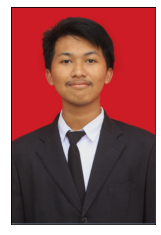

In [ ]:
def showImage(img):
    plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    plt.show()
im = Image.open('img_rlc.png')
im = np.array(im)

print(im.shape)
showImage(im)

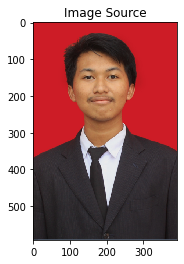

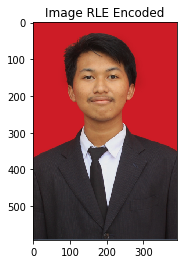

Memory size Before :  197529  bytes
Memory size After  :  197529  bytes
Compression ratio Before - After:  0.00000 %
MSE:  0.0
PSNR:  100  dB
SNR:  2.8959633132948785  dB
SNR:  2.8959633132948785  dB


In [ ]:
# read file
hehe1 = Image.open('foto_rgb.png')
hehe1 = np.array(hehe1)
hehe2 = Image.open('img_rlc.png')
hehe2 = np.array(hehe2)

# show result
plt.subplot(1,2,1)
plt.title("Image Source")
plt.imshow(hehe1, interpolation='nearest',cmap='gray')
plt.show()

plt.subplot(1,2,2)
plt.title("Image RLE Encoded")
plt.imshow(hehe2, interpolation='nearest',cmap='gray')
plt.show()

# size ratio
import os
msize_awal = os.path.getsize('foto_rgb.png')
msize_akhir = os.path.getsize('img_rlc.png')
print("Memory size Before : ",msize_awal," bytes")
print("Memory size After  : ",msize_akhir," bytes")

# compression ratio BnW
bnw_fix = ((msize_awal - msize_akhir)*100)/msize_awal
formatted_ratio_bnw = "{:.5f}".format(bnw_fix)
print("Compression ratio Before - After: ", formatted_ratio_bnw, "%")

# show MSE
import numpy as np
print("MSE: ", np.square(np.subtract(hehe1,hehe2)).mean())

# PSNR function
from math import log10, sqrt
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

print("PSNR: ", PSNR(hehe1,hehe2), " dB")

#SNR function
import scipy.io
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

print("SNR: ", signaltonoise(hehe1).flatten().mean(), " dB")
print("SNR: ", signaltonoise(hehe2).flatten().mean(), " dB")